In [138]:
import os
GOOGLE_APPLICATION_CREDENTIALS = "/Users/zacharynguyen/Documents/GitHub/2024/Applied-Generative-AI/IAM/zacharynguyen-genai-656c475b142a.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_APPLICATION_CREDENTIALS

In [139]:
PROJECT_ID = 'zacharynguyen-genai' # replace with project ID
os.environ["PROJECT_ID"] = PROJECT_ID

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [140]:
#!pip install -r requirements.txt 


### API Enablement

In [141]:
#!gcloud auth login

In [142]:
#!gcloud services enable aiplatform.googleapis.com
#!gcloud services enable documentai.googleapis.com

---
## Setup

Inputs

In [143]:
project = !gcloud config get-value project
project[1]


'zacharynguyen-genai'

In [144]:
PROJECT_ID='zacharynguyen-genai'
REGION = 'us-central1'
EXPERIMENT = 'mlb-rules'
SERIES = 'applied-genai-v3'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2]

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf']

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "How is baseball played?"

Packages

In [145]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time
import asyncio

import PyPDF2
import IPython
import PIL, PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import vertexai.language_models # PaLM and Codey Models
import vertexai.generative_models # for Gemini Models
from google.cloud import documentai
from google.cloud import storage
from google.cloud import bigquery
from google.api_core import retry

### Create GCS Bucket

In [146]:
def create_gcs_bucket(project_id, bucket_name, region):
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    new_bucket = storage_client.create_bucket(bucket, location=region)
    print(f"Bucket {new_bucket.name} created.")
    return new_bucket

In [147]:
# Create GCS Bucket
#create_gcs_bucket(PROJECT_ID, GCS_BUCKET, REGION)

### Create dataset and table in BigQuery

In [148]:
def create_bq_dataset_and_table(project_id, dataset_id, table_id, region):
    """
    Creates a new dataset and table in BigQuery.

    Parameters:
    - project_id: Your GCP project ID.
    - dataset_id: The ID of the dataset to create.
    - table_id: The ID of the table to create within the dataset.
    - region: The region where the dataset will be located.

    Returns:
    - Table: The created BigQuery table object.
    """
    bq_client = bigquery.Client(project=project_id)

    # Create the dataset
    dataset_ref = bigquery.DatasetReference(project_id, dataset_id)
    dataset = bigquery.Dataset(dataset_ref)
    dataset.location = region
    created_dataset = bq_client.create_dataset(dataset, exists_ok=True)
    print(f"Dataset {created_dataset.dataset_id} created in project {project_id}.")

    # Create the table
    schema = [
        bigquery.SchemaField("example_field", "STRING", mode="NULLABLE")
    ]
    table_ref = dataset_ref.table(table_id)
    table = bigquery.Table(table_ref, schema=schema)
    created_table = bq_client.create_table(table, exists_ok=True)
    print(f"Table {created_table.table_id} created in dataset {created_dataset.dataset_id}.")

    return created_table

In [149]:

# Create BigQuery Dataset and Table
#create_bq_dataset_and_table(PROJECT_ID, BQ_DATASET, BQ_TABLE, BQ_REGION)

Clients

In [150]:
from google.cloud import documentai, bigquery, storage
import vertexai

# Initialize Vertex AI
vertexai.init(project=PROJECT_ID, location=REGION)

# Setup Document AI clients
LOCATION = REGION.split('-')[0]
docai_endpoint = f"{LOCATION}-documentai.googleapis.com"
docai_client_options = {"api_endpoint": docai_endpoint}

# Document AI synchronous client
docai_client = documentai.DocumentProcessorServiceClient(client_options=docai_client_options)

# Document AI asynchronous client
docai_async_client = documentai.DocumentProcessorServiceAsyncClient(client_options=docai_client_options)

# Initialize BigQuery client
bq = bigquery.Client(project=PROJECT_ID)

# Initialize Google Cloud Storage (GCS) client and get the bucket
gcs = storage.Client(project=PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# Print confirmation that clients have been initialized successfully
print("Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.")


Initialized Vertex AI, Document AI, BigQuery, and GCS clients successfully.


---
## Vertex LLM Setup

> For a detailed overview of all the genative AI models and their APIs check out the companion notebook: [Getting Started - Vertex AI GenAI Python Client](./Getting%20Started%20-%20Vertex%20AI%20GenAI%20Python%20Client.ipynb)

With the [vertexai](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai) client there are packages for the types of data being interacted with.  There is also a higher package for preview models (not yet in GA).

> **NOTE:** In can be helpful to review the API Documentation at it's source in GitHub for up to the moment release information: [github/googleapis/python-aiplatform](https://github.com/googleapis/python-aiplatform/tree/main)

Gemini Text and Multimodal Models:
- [vertexai.generative_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.generative_models)
    - [vertexai.preview.generative_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.generative_models)

Language Models (PaLM and Codey Models):
- [vertexai.language_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models)
    - [vertexai.preview.language_models()](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.preview.language_models)

In [151]:
# Gemini Models
gemini_text = vertexai.generative_models.GenerativeModel("gemini-1.0-pro")

# PaLM Models
textembed_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko')
text_model_b = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison')
text_model_b32 = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison-32k')
text_model_u = vertexai.language_models.TextGenerationModel.from_pretrained('text-unicorn')

### Prompt

In [152]:
question

'How is baseball played?'

### Embeddings

In [153]:
textembed_model.get_embeddings([question])[0].values[0:5]

[0.02580685168504715,
 -0.032582469284534454,
 -0.019206473603844643,
 0.017240362241864204,
 -0.002174351131543517]

### Generation: PaLM `text-bison`

In [154]:
response = text_model_b.predict(question)
response

 **Objective:**
The objective of baseball is to score runs by hitting the ball and advancing around the bases. The team with the most runs at the end of the game wins.

**Gameplay:**
- A baseball game is played between two teams, each with nine players on the field.
- The game is divided into nine innings, each consisting of two halves: the top of the inning when the visiting team bats, and the bottom of the inning when the home team bats.
- Each team takes turns batting and fielding. The batting team tries to hit the ball into fair territory (between the foul lines) and advance around

In [155]:
response.safety_attributes

{'Derogatory': 0.1, 'Insult': 0.1, 'Sexual': 0.1}

In [156]:
response = text_model_b.predict(question, max_output_tokens = 500)
response

 **Objective:**
The objective of baseball is to score runs by hitting the ball and advancing around the bases. The team with the most runs at the end of the game wins.

**Gameplay:**
- A baseball game is played between two teams, each with nine players on the field.
- The game is divided into nine innings, each consisting of two halves: the top of the inning when the visiting team bats, and the bottom of the inning when the home team bats.
- Each team takes turns batting and fielding. The batting team tries to hit the ball into fair territory (between the foul lines) and advance around the bases. The fielding team tries to prevent the batters from reaching base and to get them out.

**Basic Rules:**
- A player can advance around the bases by hitting the ball and reaching first base, or by being walked (awarded first base without hitting the ball), or by being hit by a pitch.
- A player can also advance around the bases by stealing (running to the next base while the pitcher is deliveri

In [157]:
IPython.display.Markdown(response.text)

 **Objective:**
The objective of baseball is to score runs by hitting the ball and advancing around the bases. The team with the most runs at the end of the game wins.

**Gameplay:**
- A baseball game is played between two teams, each with nine players on the field.
- The game is divided into nine innings, each consisting of two halves: the top of the inning when the visiting team bats, and the bottom of the inning when the home team bats.
- Each team takes turns batting and fielding. The batting team tries to hit the ball into fair territory (between the foul lines) and advance around the bases. The fielding team tries to prevent the batters from reaching base and to get them out.

**Basic Rules:**
- A player can advance around the bases by hitting the ball and reaching first base, or by being walked (awarded first base without hitting the ball), or by being hit by a pitch.
- A player can also advance around the bases by stealing (running to the next base while the pitcher is delivering the ball).
- A player scores a run when they touch home plate after advancing around all the bases.
- The team with the most runs at the end of the game wins. If the game is tied after nine innings, extra innings are played until one team scores more runs than the other.

**Key Positions:**
- Pitcher: The pitcher throws the ball to the batter.
- Catcher: The catcher crouches behind home plate and receives the pitches from the pitcher.
- First baseman: The first baseman plays near first base and is responsible for catching throws from the pitcher and fielders.
- Second baseman: The second baseman plays near second base and is responsible for catching throws from the pitcher and fielders.
- Shortstop: The shortstop plays between second and third base and is responsible for catching throws from the pitcher and fielders.
- Third baseman: The third baseman plays near third base and is responsible for catching throws from the pitcher and fielders.
- Outfielders: The outfielders play in the outfield (the area beyond the infield) and are responsible for catching fly balls.

**Scoring:**
- A team scores a run when a player touches home plate after advancing around all the bases.
- A player can score a run by hitting a home run (hitting the ball over the outfield fence), or by being walked (awarded first base

### Generation: PaLM `text-unicorn`

In [158]:
response = text_model_u.predict(question)
response

Baseball is a bat-and-ball game played between two teams of nine players each. The game is played on a field with four bases arranged in a diamond shape. The objective of the game is to score runs by hitting the ball and running around the bases.

The game begins with one team batting and the other team fielding. The pitcher throws the ball to the batter, who tries to hit it with the bat. If the batter hits the ball, they run to first base. If they reach first base safely, they can continue running to second, third, and home base. If they reach home base, they score

In [159]:
IPython.display.Markdown(response.text)

Baseball is a bat-and-ball game played between two teams of nine players each. The game is played on a field with four bases arranged in a diamond shape. The objective of the game is to score runs by hitting the ball and running around the bases.

The game begins with one team batting and the other team fielding. The pitcher throws the ball to the batter, who tries to hit it with the bat. If the batter hits the ball, they run to first base. If they reach first base safely, they can continue running to second, third, and home base. If they reach home base, they score

### Generation: PaLM `text-bison-32k`

In [160]:
response = text_model_b32.predict(question)
response

 **Objective:**
The objective of baseball is to score runs by hitting the ball and advancing around the bases. The team with the most runs at the end of the game wins.

**Gameplay:**
- A baseball game is played between two teams, each with nine players on the field.
- The game is divided into nine innings, each consisting of two halves: the top of the inning when the visiting team bats, and the bottom of the inning when the home team bats.
- Each team takes turns batting and fielding. The batting team tries to hit the ball into fair territory (between the foul lines) and advance around

In [161]:
IPython.display.Markdown(response.text)

 **Objective:**
The objective of baseball is to score runs by hitting the ball and advancing around the bases. The team with the most runs at the end of the game wins.

**Gameplay:**
- A baseball game is played between two teams, each with nine players on the field.
- The game is divided into nine innings, each consisting of two halves: the top of the inning when the visiting team bats, and the bottom of the inning when the home team bats.
- Each team takes turns batting and fielding. The batting team tries to hit the ball into fair territory (between the foul lines) and advance around

### Generation: Gemini `gemini-1.0-pro`

In [162]:
response = gemini_text.generate_content(question)
response

candidates {
  content {
    role: "model"
    parts {
      text: "**Objective:**\nThe goal of baseball is to score more runs than the opposing team by advancing runners around the four bases (home plate, first base, second base, third base) and crossing home plate.\n\n**Gameplay:**\n\n1. **Innings:** A full game consists of nine innings, with each team batting and fielding for one half-inning.\n\n2. **Teams:** Two teams of nine players each take turns batting (trying to hit the ball) and fielding (trying to prevent runs).\n\n3. **Field:** Baseball is played on a diamond-shaped field with four bases positioned at each corner.\n\n4. **Pitching:** The pitcher throws the ball over home plate towards the batter, who attempts to hit it.\n\n5. **Batting:** The batter stands in front of home plate and swings at the pitched ball, aiming to hit it into the field of play.\n\n6. **Running:** If the batter hits the ball, they become a runner and attempt to advance around the bases by running in o

In [163]:
print(response.text)

**Objective:**
The goal of baseball is to score more runs than the opposing team by advancing runners around the four bases (home plate, first base, second base, third base) and crossing home plate.

**Gameplay:**

1. **Innings:** A full game consists of nine innings, with each team batting and fielding for one half-inning.

2. **Teams:** Two teams of nine players each take turns batting (trying to hit the ball) and fielding (trying to prevent runs).

3. **Field:** Baseball is played on a diamond-shaped field with four bases positioned at each corner.

4. **Pitching:** The pitcher throws the ball over home plate towards the batter, who attempts to hit it.

5. **Batting:** The batter stands in front of home plate and swings at the pitched ball, aiming to hit it into the field of play.

6. **Running:** If the batter hits the ball, they become a runner and attempt to advance around the bases by running in order: first base, second base, third base, and home plate.

7. **Fielding:** The fi

In [164]:
IPython.display.Markdown(response.text)

**Objective:**
The goal of baseball is to score more runs than the opposing team by advancing runners around the four bases (home plate, first base, second base, third base) and crossing home plate.

**Gameplay:**

1. **Innings:** A full game consists of nine innings, with each team batting and fielding for one half-inning.

2. **Teams:** Two teams of nine players each take turns batting (trying to hit the ball) and fielding (trying to prevent runs).

3. **Field:** Baseball is played on a diamond-shaped field with four bases positioned at each corner.

4. **Pitching:** The pitcher throws the ball over home plate towards the batter, who attempts to hit it.

5. **Batting:** The batter stands in front of home plate and swings at the pitched ball, aiming to hit it into the field of play.

6. **Running:** If the batter hits the ball, they become a runner and attempt to advance around the bases by running in order: first base, second base, third base, and home plate.

7. **Fielding:** The fielders attempt to catch or field the batted ball and throw it to a base to try to get a runner out.

8. **Outs:** A runner can be dismissed, or "out," in several ways:
   - By being thrown out at a base
   - By being tagged with the ball
   - By striking out (failing to hit the ball after three pitches)

9. **Runs:** A runner scores a run when they return to home plate after successfully advancing around all four bases.

10. **Winning:** The team with the most runs at the end of the game wins.

**Additional Rules:**

* **Strike zone:** The area over home plate where the batter must swing at a pitched ball.
* **Ball and strike:** A pitch that is outside the strike zone is a "ball," while a pitch that is in the strike zone is a "strike."
* **Foul ball:** A ball that is hit outside the field of play.
* **Home run:** A hit that allows the batter to circle all four bases and score a run.
* **Innings:** Each team gets three outs per inning. Once three outs are recorded, the teams switch roles (batting and fielding).

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [165]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks')

(True, True)

In [166]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    # do a check for prior run and present message if found letting user know the prior result exists but not being used
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')

elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Importing previous run from GCS')

    # load files_pages: the file+page level information including docai responses in `parsing`
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
    files_pages_chunks = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True

elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Importing previous run from BigQuery')

    # load files_pages: the file+page level information including docai responses in `parsing`
    files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # convert json string to dictionary:
    for page in files_pages:
        page['parsing'] = json.loads(page['parsing'])
    
    # load files_pages_chunks: the chunks parsed from the files+pages
    files_pages_chunks = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_chunks`').to_dataframe().to_dict('records')
    #convert json string to dictionary:
    for chunk in files_pages_chunks:
        chunk['metadata'] = json.loads(chunk['metadata'])
    # sort chunk by file, page, chunk number:
    files_pages_chunks = sorted(files_pages_chunks, key = lambda x: (x['metadata']['file_index'], x['metadata']['page_index'], x['metadata']['chunk']))

    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
        
else:
    print('No previous run available to import')
    PRIOR_PARSE = False

Importing previous run from GCS


---
## Get/Create Document AI Processors

Document AI is comprised of multiple processors.  In this case the Form parser is used for its ability to detect and extract tables as well as OCR.  For a more thorough review of Document AI processors, including customized parsers, see the [Working With/Document AI](../Working%20With/Document%20AI/readme.md) section of this repository.  This repository includes example of processing document at larger scales and storing the data for processing and retrieval.

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors).

In [167]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.1-2023-06-26'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
    if p.display_name == PARSER_DISPLAY_NAME:
        parser = p
try:
    print('Retrieved existing parser: ', parser.name)
except Exception:
    parser = docai_client.create_processor(
        parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
        processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
    )
    print('Created New Parser: ', parser.name)

Retrieved existing parser:  projects/67031084133/locations/us/processors/ab4bd266099f2e0c


---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [168]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    document_locations = []
    for source_document in source_documents:
        if source_document.startswith('http'):
            document_locations.append('URL')
            print(f'Use requests to get online document: {source_document}')
        elif source_document.startswith('gs'):
            document_locations.append('GCS')
            print(f'Use GCS to get document in GCS: {source_document}')
        else:
            document_locations.append('UNKNOWN')
            print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Using Prior Results


Import the PDF to memory as bytes:

In [169]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    imported_documents = []
    for s, source_document in enumerate(source_documents):
        if document_locations[s] == 'URL':
            imported_documents.append(requests.get(source_document).content)
        elif document_locations[s] == 'GCS':
            blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
            imported_documents.append(blob.download_as_bytes())
        elif document_locations[s] == 'UNKNOWN':
            imported_documents.append(None)
    type(imported_documents[0])       

Using Prior Results


Convert from bytes to PDF:

In [170]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    converted_documents = []
    for imported_document in imported_documents:
        if imported_document:
            converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
        else:
            converted_documents.append(None)
        type(converted_documents[0])    

Using Prior Results


Review number of pages per PDF:

In [171]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    for f, file in enumerate(converted_documents):
        if file:
            print(f"{source_documents[f]} has {len(file.pages)} pages")

Using Prior Results


Split PDF(s) to list of individual pages for each file:

List of dictionaries with keys: file_index, page_index, raw_file_page

In [172]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    # list of tuples (file index, page number, page content)
    files_pages = []
    for c, converted_document in enumerate(converted_documents):
        if converted_document:
            for page_num, page in enumerate(converted_document.pages, 1):
                writer = PyPDF2.PdfWriter()
                writer.add_page(page)
                with io.BytesIO() as bytes_stream:
                    files_pages.append(
                        dict(file_index = c, page_index = page_num, raw_file_page = writer.write(bytes_stream)[1].getbuffer().tobytes())
                    )
len(files_pages)

Using Prior Results


192

---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 requests per minute per project. The code below implements waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [173]:
async def docai_runner(files_pages, limit_concur_requests = 120):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await docai_async_client.process_document(
                        request = dict(
                            raw_document = documentai.RawDocument(
                                content = files_pages[p]['raw_file_page'],
                                mime_type = 'application/pdf'
                            ),
                            name = parser.name
                        )
                    )
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = documentai.Document.to_dict(result.document)
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    # add parsing to input list of dictionaries for all the pages
    for c, content in enumerate(files_pages):
        content['parsing'] = results[c]
    
    return

In [174]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    await docai_runner(files_pages)
    # remove the raw file page
    for page in files_pages: del page['raw_file_page']

Using Prior Results


In [175]:
len(files_pages)

192

In [176]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [177]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [178]:
async def embedding_pages(files_pages, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    if files_pages[p]['parsing']['text']:
                        result = await textembed_model.get_embeddings_async([files_pages[p]['parsing']['text']])
                    else:
                        obj = lambda: None
                        obj.values = [None]
                        result = [obj]
                    
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages))]
    responses = await asyncio.gather(*tasks)
    
    for c, content in enumerate(files_pages):
        content['parsing']['embedding'] = results[c]
    
    return

In [179]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    await embedding_pages(files_pages)
    for c, content in enumerate(files_pages):
        document_image = PIL.Image.open(
            io.BytesIO(
                base64.decodebytes(content['parsing']['pages'][0]['image']['content'].encode('utf-8'))
            )
        )
        content['parsing']['path'] = source_documents[content['file_index']][:(-1*len(source_documents[content['file_index']].split('/')[-1]))]
        content['parsing']['file'] = source_documents[content['file_index']].split('/')[-1]
        content['parsing']['page'] = content['page_index']
        content['parsing']['vme_id'] = f"{content['file_index']}_{content['page_index']}"
        content['parsing']['dimensions'] = list(document_image.size)
        if not content['parsing']['text']:
            content['parsing']['embedding'] = []

Using Prior Results


In [180]:
len(files_pages)

192

In [181]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [182]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

### Parse Chunks From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [183]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_chunks = []
    
    for content in files_pages:
        page = content['parsing']
        chunk_id = 0
        
        # parse tables from page:
        tables = []
        for t, table in enumerate(page['pages'][0]['tables']):

            table_txt = ''
            if 'text_anchor' in table['layout'].keys():
                for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                    if t == 0 and s == 0: start = 0
                    else: start = int(segment['start_index'])
                    end = int(segment['end_index'])
                    table_txt += page['text'][start:end+t]

            vertices = []
            normalized_vertices = []
            for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

            if table_txt != '':
                files_pages_chunks.append(
                    dict(
                        text = table_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            table = t + 1,
                            chunk = chunk_id + 1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1       
        
        # parse paragraphs from page - not in tables or overlapping tables
        for g, paragraph in enumerate(page['pages'][0]['paragraphs']):

            # get the paragraph text
            paragraph_txt = ''
            for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                if g == 0 and s == 0: start = 0
                else: start = int(segment['start_index'])
                end = int(segment['end_index'])
                paragraph_txt += page['text'][start:end+1]

            # if paragraph not empty, get/calc the vertices
            if paragraph_txt != '':
                use_paragraph = True
                vertices = []
                normalized_vertices = []
                for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                    normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                    vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
            else:
                use_paragraph = False

            # only use paragraphs that are not within/overlapping table boundaries
            if use_paragraph:
                for t_shape in tables:
                    p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                    if p_shape.intersects(t_shape):
                        use_paragraph = False

            # save the paragraph as an element
            if use_paragraph:
                files_pages_chunks.append(
                    dict(
                        text = paragraph_txt,
                        metadata = dict(
                            file_index = content['file_index'],
                            page_index = content['page_index'],
                            paragraph = g + 1,
                            chunk = chunk_id +1,
                            vme_id = page['vme_id'] + '_' + str(chunk_id),
                            vertices = vertices,
                            normalized_vertices = normalized_vertices
                        )
                    )
                )
                chunk_id += 1        

Using Prior Document Preparation


In [184]:
len(files_pages_chunks)

2192

In [185]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [186]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Get Embeddings


The `textembedding-gecko` model has quota of 1500 request per minute:
- [Quotas by region and model](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#quotas_by_region_and_model)

In [187]:
async def embedding_runner(files_pages_chunks, limit_concur_requests = 500):
    limit = asyncio.Semaphore(limit_concur_requests)
    results = [None] * len(files_pages_chunks)
    
    # make requests - async
    async def make_request(p):
        
        async with limit:
            if limit.locked():
                await asyncio.sleep(0.01)
                
            ########### manual Error Handling ############################################
            fail_count = 0
            while fail_count <= 20:
                try:
                    result = await textembed_model.get_embeddings_async([files_pages_chunks[p]['text']])
                    if fail_count > 0:
                        print(f'Item {p} succeeded after fail count = {fail_count}')
                    break
                except:
                    fail_count += 1
                    #print(f'Item {p} failed: current fail count = {fail_count}')
                    await asyncio.sleep(2^(min(fail_count, 6) - 1))
            ##############################################################################
            
        results[p] = result[0].values
    
    # manage tasks
    tasks = [asyncio.create_task(make_request(p)) for p in range(len(files_pages_chunks))]
    responses = await asyncio.gather(*tasks)
    
    # add embeddings to input list of dictionaries for all the chunks
    for c, content in enumerate(files_pages_chunks):
        content['embedding'] = results[c]
    
    await asyncio.sleep(60)
    
    return

In [188]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    await embedding_runner(files_pages_chunks)

Embeddings created on previous run.


In [189]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [190]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

In [191]:
files_pages_chunks[0]['embedding'][0:5]

[0.03293042257428169,
 -0.028437461704015732,
 -0.016283292323350906,
 -0.01963704638183117,
 0.03900976479053497]

---
## Save Files For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [192]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [193]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [194]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_chunks.json')
        blob.upload_from_string('\n'.join([json.dumps(chunk) for chunk in files_pages_chunks]), content_type = 'application/json')

    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = BQ_REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)  

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("file_index", "INT64"),
                    bigquery.SchemaField("page_index", "INT64"),
                    bigquery.SchemaField("parsing", "JSON")
                ]
            ) 
        )
        load_job.result()
        
        # save files_pages_chunks
        load_job = bq.load_table_from_json(
            json_rows = files_pages_chunks,
            destination = ds.table(BQ_TABLE + '_files_pages_chunks'),
            job_config = bigquery.LoadJobConfig(
                source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
                write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE, #.WRITE_EMPTY
                create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED, #.CREATE_NEVER
                #schema_update_options = [bigquery.SchemaUpdateOption.ALLOW_FIELD_ADDITION],
                #autodetect = True
                schema = [
                    bigquery.SchemaField("text", "STRING"),
                    bigquery.SchemaField("metadata", "JSON"),
                    bigquery.SchemaField("embedding", "FLOAT", "REPEATED")
                ]
            ) 
        )
        load_job.result()

This run loaded results from a prior run.  Not overwriting.


---
## Embeddings Search: AKA Vector Search

There are many ways to do vector search. In production there are considerations, including:
- How many indexes?
- What is the size of indexes?
- What is the lifespan and frequency of indexes?
- How frequently will indexes get updates (append, update, delete)?
- How quickly do updates need to surface in searches?
- What is the next step after a search?  Does the coorespondinng text need to be retrieved separately?

This notebook is designed to show the workflow across a few documents and uses brute for search of all embeddings locally using the common Python package `numpy`.  But what about scaling in production?

Google Cloud offers solutions for any workflow!
- Local to the application:
    - [ScAAN](https://github.com/google-research/google-research/tree/master/scann)
    - [Faiss](https://github.com/facebookresearch/faiss)
- With transactional data:
    - using [pgvector](https://github.com/pgvector/pgvector) with:
        - [Cloud SQL for PostgreSQL](https://cloud.google.com/sql/docs/postgres)
        - [AlloyDB for PostgreSQL](https://cloud.google.com/alloydb/docs)
        - blogs:
            - [Building AI-powered apps on Google Cloud databases using pgvector, LLMs and LangChain](https://cloud.google.com/blog/products/databases/using-pgvector-llms-and-langchain-with-google-cloud-databases)
    - [Spanner](https://cloud.google.com/spanner/docs)
        - [Vector Search in Spanner](https://cloud.google.com/spanner/docs/find-k-nearest-neighbors)
        - [langchain with Spanner](https://github.com/googleapis/langchain-google-spanner-python)
- In the data warehouse:
    - [BigQuery Vector Indexes](https://cloud.google.com/bigquery/docs/vector-search-intro)
- Fit-for-purpose: Fast, Scalable, and Flexible:
    - [Vertex AI Feature Store](https://cloud.google.com/vertex-ai/docs/featurestore/latest/overview) with built-in [Search using embeddings](https://cloud.google.com/vertex-ai/docs/featurestore/latest/embeddings-search) 
    - [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview)

### Get Embedding for Question

In [195]:
print(question)

How is baseball played?


In [196]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
query_embed.shape

(768,)

### Create Local Embedding DB - With Numpy!

In [197]:
embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])
embed_db.shape

(2192, 768)

### Get Matches - With Numpy!

#### Dot Product

- measures alignment between two vectors
- large positive implies similar directions
- large negative implies opposite directions
- near zero implies orthoganal
- larger is more similar
- best for:
    - matching and retrieval


In [198]:
similarity = np.dot(query_embed, embed_db.T)
similarity.shape

(2192,)

In [199]:
# larger is more similar
matches = np.argsort(similarity)[::-1][:5].tolist()
matches = [(match, similarity[match]) for match in matches]
matches

[(1809, 0.7540034185030964),
 (1709, 0.7415698233410504),
 (2078, 0.7414898579941103),
 (69, 0.7408109347416857),
 (271, 0.7401550384055198)]

In [200]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

A PITCH is a ball delivered to the batter by the pitcher.
(
A BATTER is an offensive player who takes his position in the
batter's box.
B
Baseball 3.01;
B
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
8
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
333
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot From Plate
38
(f) Ambidextrous Pitchers
38
5.08 How a Team Scores
39
5.09 Making an Out
41
(a) Retiring the Batter
41
(b) Retiring a Runner
4489
45
(c) Appeal Plays
50

When the ball is put in play at the start of, or during a game, all
fielders other than the catcher shall be on fair territory

#### Cosine Similarity

- measures angle between two vectors
- represents the cosine of the angles resulting in values -1 to 1
- larger is more similar
- best for:
    - grouping for topics: different magnitudes can still group together
    - collaborative filtering for recommendation systems


In [201]:
cosine_similarity = similarity / (np.linalg.norm(query_embed) * np.linalg.norm(embed_db, axis = 1).T)
cosine_similarity.shape

(2192,)

In [202]:
# larger is more similar
matches = np.argsort(cosine_similarity)[::-1][:5].tolist()
matches = [(match, cosine_similarity[match]) for match in matches]
matches

[(1809, 0.7540053519391599),
 (1709, 0.7415717590653041),
 (2078, 0.7414915852637205),
 (69, 0.7408145118470847),
 (271, 0.740157224543138)]

In [203]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

A PITCH is a ball delivered to the batter by the pitcher.
(
A BATTER is an offensive player who takes his position in the
batter's box.
B
Baseball 3.01;
B
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
8
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
333
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot From Plate
38
(f) Ambidextrous Pitchers
38
5.08 How a Team Scores
39
5.09 Making an Out
41
(a) Retiring the Batter
41
(b) Retiring a Runner
4489
45
(c) Appeal Plays
50

When the ball is put in play at the start of, or during a game, all
fielders other than the catcher shall be on fair territory

#### Euclidean Distance

- straight line distance between two vector points
- smaller is more similar
- note that smaller magnitude vectors with large angles may be deemed more similar than larger magnitude vectors with small angles
- best for:
    - clustering points in vector space
    - anomaly detection

In [204]:
euclidean_similarity = np.linalg.norm(embed_db - query_embed, axis = 1)
euclidean_similarity.shape

(2192,)

In [205]:
# smaller is more similar
matches = np.argsort(euclidean_similarity)[:5].tolist()
matches = [(match, euclidean_similarity[match]) for match in matches]
matches

[(1809, 0.7014185872591264),
 (1709, 0.718926375033827),
 (2078, 0.7190379858577195),
 (69, 0.7199781061248378),
 (271, 0.7208911262903526)]

In [206]:
for match in matches:
    print(files_pages_chunks[match[0]]['text'])

A PITCH is a ball delivered to the batter by the pitcher.
(
A BATTER is an offensive player who takes his position in the
batter's box.
B
Baseball 3.01;
B
5.00 PLAYING THE GAME
5.01 Starting the Game ("Play Ball!")
18
8
5.02 Fielding Positions
18
5.03 Base Coaches
20
5.04 Batting.
20
(a) Batting Order
20
(b) The Batter's Box
21
(c) Completing Time at Bat
24
5.05 When the Batter Becomes a Runner
24
5.06 Running the Bases
27
(a) Occupying the Base
27
(b) Advancing Bases
27
(c) Dead Balls
32
5.07 Pitching
34
(a) Legal Pitching Delivery
34
333
(1) The Windup Position
35
(2) The Set Position
36
(b) Warm-Up Pitches
37
(c) Pitcher Delays
37
(d) Throwing to the Bases
38
(e) Effect of Removing Pivot
Foot From Plate
38
(f) Ambidextrous Pitchers
38
5.08 How a Team Scores
39
5.09 Making an Out
41
(a) Retiring the Batter
41
(b) Retiring a Runner
4489
45
(c) Appeal Plays
50

When the ball is put in play at the start of, or during a game, all
fielders other than the catcher shall be on fair territory

### Search Function: Pages

Using dot product, create an embedding database and accompanying search function.

In [207]:
pages_embed_db = np.array([page['parsing']['embedding'] if page['parsing']['embedding'] else [0]*768 for page in files_pages])

In [208]:
def page_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, pages_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [209]:
page_match(question)

[(7, 0.7368479110541261),
 (12, 0.7211528290650577),
 (29, 0.7195401049927884),
 (8, 0.7060771643490358),
 (2, 0.7021981336824621),
 (6, 0.7016567548433086),
 (9, 0.6974221316899606)]

### Search Function: Chunks

Using dot product, create an embedding database and accompanying search function.

In [210]:
chunks_embed_db = np.array([chunk['embedding'] for chunk in files_pages_chunks])

In [211]:
def chunk_match(query):
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T)
    matches = np.argsort(similarity)[::-1].tolist()
    # algorithm to dynamically pick k
    k = 1 + 3*int(10*(1-similarity[matches[0]]))
    matches = [(match, similarity[match]) for match in matches[0:k]]
    return matches

In [212]:
chunk_match(question)

[(1809, 0.7540034185030964),
 (1709, 0.7415698233410504),
 (2078, 0.7414898579941103),
 (69, 0.7408109347416857),
 (271, 0.7401550384055198),
 (999, 0.738820538938003),
 (469, 0.7385678828346383)]

---
## Visualize Relationships Between Chunks

The embeddings are incredibly high dimensional - 768!  To reduce this to a lower dimension, like 2 for plotting, the method [`t-SNE`](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) will be used.  This method models each embedding with a lower 2-dimensional point in a way that similar embeddings are modeled by nearby poiints and dissimilar embeddings by farther points.

### Visualizing Chunks

In [213]:
tsne = TSNE(random_state=0, n_iter=1000, init = 'pca', learning_rate = 'auto')
tsne_results = tsne.fit_transform(chunks_embed_db)

In [214]:
df_tsne = pd.DataFrame(data = tsne_results, columns = ["TSNE1", "TSNE2"])

(-74.31139945983887, 84.72748374938965, -57.81200542449951, 52.33438625335693)

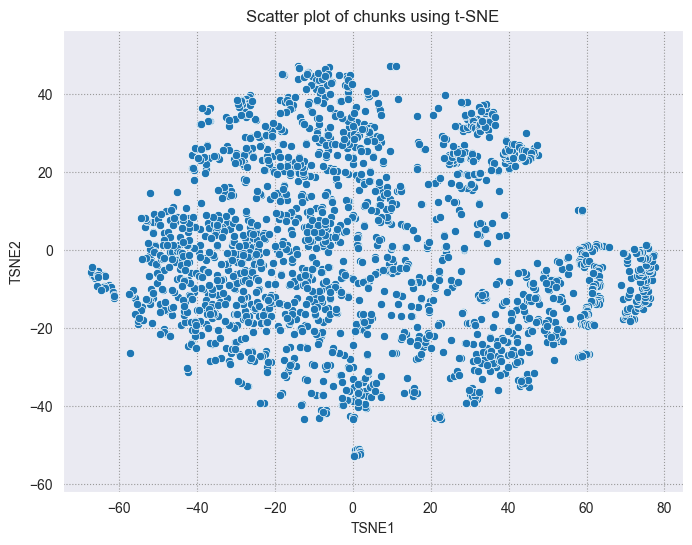

In [215]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2')
plt.title("Scatter plot of chunks using t-SNE")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Color Codeded By Similarity To Prompt

In [216]:
query_embed = np.array(textembed_model.get_embeddings([question])[0].values)
similarity = np.dot(query_embed, chunks_embed_db.T)
df_tsne['similarity'] = similarity.tolist()

(-74.31139945983887, 84.72748374938965, -57.81200542449951, 52.33438625335693)

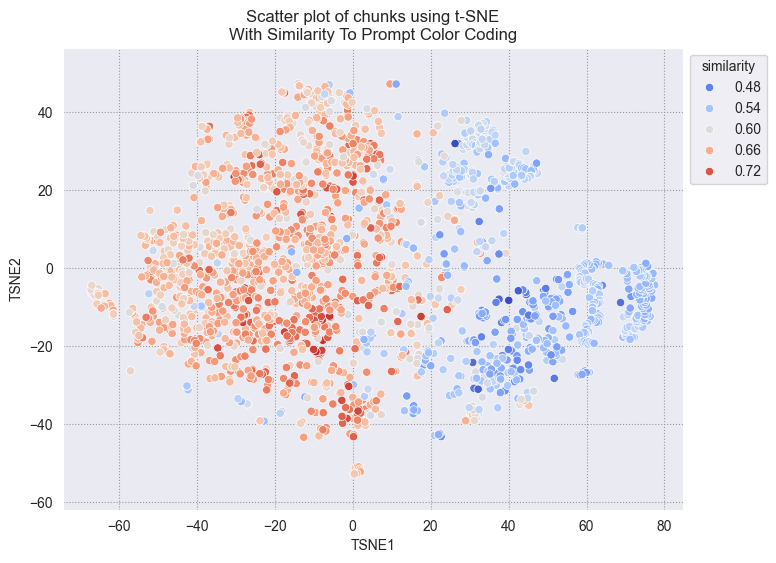

In [217]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

### Visualizing Chunks - Call Out Matches

In [218]:
matches = chunk_match(question)

In [219]:
df_tsne.iloc[[match[0] for match in matches]]

TSNE1      TSNE2  similarity
1809 -12.144868 -19.289629    0.754003
1709  -9.391647 -21.442951    0.741570
2078  17.654152 -12.546865    0.741490
69    -5.579043  13.194524    0.740811
271  -22.290195 -20.655548    0.740155
999  -30.368244  23.394104    0.738821
469   -7.679507 -18.535633    0.738568

(-74.31139945983887, 84.72748374938965, -57.81200542449951, 52.33438625335693)

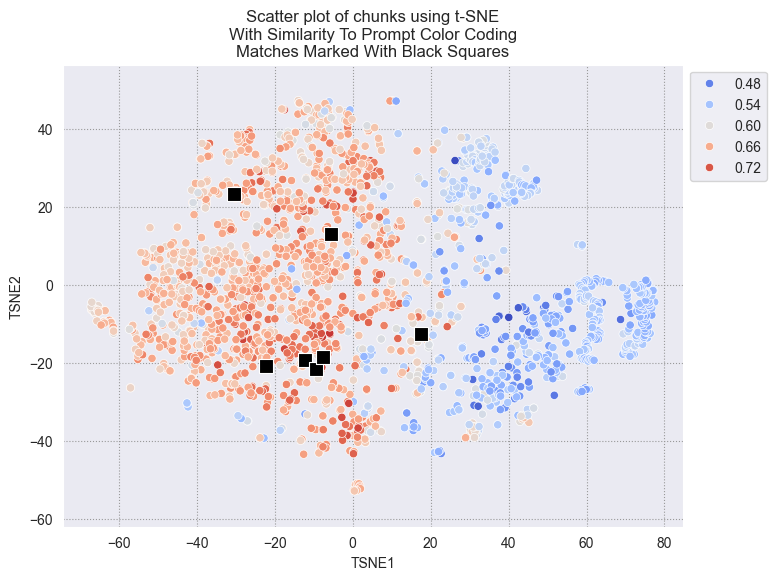

In [220]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data = df_tsne, x = 'TSNE1', y = 'TSNE2', hue = 'similarity', palette = sns.color_palette('coolwarm', as_cmap=True))
sns.scatterplot(data = df_tsne.iloc[[match[0] for match in matches]], x="TSNE1", y="TSNE2", color = 'black', marker = 's', s = 100)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Scatter plot of chunks using t-SNE\nWith Similarity To Prompt Color Coding\nMatches Marked With Black Squares")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.axis("equal")

---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [221]:
files_pages[0].keys()

dict_keys(['file_index', 'page_index', 'parsing'])

In [222]:
files_pages[0]['parsing'].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'embedding', 'path', 'file', 'page', 'vme_id', 'dimensions'])

In [223]:
files_pages_chunks[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [224]:
files_pages_chunks[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'chunk', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

### Functions For Bot

#### Retrieval Functions

These retrieve context.

**NOTE**: `get_retrieval` calls `expand_retrieval` which call `get_retrieval`.  This can lead to infinate recursion but is prevent by `expand_retrieval` calling `get_retrieval` with `DISTANCE` left at default to prevent a further call to `expand_retrieval`.  Max recursion is 1 in this case. 

In [225]:
def get_chunks(query, k = -1, simk = -1):
    # k set the number of matches to retrieve, regarless of similarity. k = -1 will trigger calculating k dynamically.
    # simk sets a threshold for similarity: <=0 uses k, (0,1] will get all matches with similarity in range [1-simk, 1] 
    
    query_embed = np.array(textembed_model.get_embeddings([query])[0].values)
    similarity = np.dot(query_embed, chunks_embed_db.T) # for dot product, higher is better match, since normalized embeddings 1 is best, 0 is worst
    matches = np.argsort(similarity)[::-1].tolist()
    
    if k <= 0:
        # algorithm to dynamically pick k
        k = 1 + 3*int(10*(1-similarity[matches[0]]))
    if simk <= 0:
        matches = [(match, similarity[match]) for match in matches[0:k]]
    elif simk > 0 and simk <= 1:
        indicies = np.where(similarity >= 1-simk)[0]
        matches = [(i, similarity[i]) for i in indicies]
     
    return matches

def expand_retrieval(contexts, DISTANCE):
    
    additional_contexts = []
    if DISTANCE > 0:
        
        # for each page look for surrounding chunks, collect chunks
        chunk_indexes = []
        for context in contexts:
            # get matches for the page from contexts
            matches = get_retrieval(context[2], simk = DISTANCE, file_page = (context[3]['file_index'], context[3]['page_index']))
            for match in matches:
                if match[0] not in chunk_indexes and match[0] not in [c[0] for c in contexts]:
                    chunk_indexes += [match[0]]
                    additional_contexts.append(match)

    return additional_contexts

def get_retrieval(question, k = -1, simk = -1, DISTANCE = 0, file_page = None):

    if file_page: # this is from a call to this function by expand_retrieval
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], True) for match in get_chunks(question, k = k, simk = simk) if file_page == (files_pages_chunks[match[0]]['metadata']['file_index'], files_pages_chunks[match[0]]['metadata']['page_index'])]
    else: # this is from a call to this function by the main function: document_bot
        matches = [match + (files_pages_chunks[match[0]]['text'], files_pages_chunks[match[0]]['metadata'], False) for match in get_chunks(question, k = k, simk = simk)]
    
    if DISTANCE > 0:
        matches = matches + expand_retrieval(matches, DISTANCE)
    
    return matches

#### Augmentation Functions

This function prepares the prompt by also adding retrieved context = augmenting.

In [226]:
def get_augmented(question, contexts, ground):
    prompt = ''
    
    if ground:
        prompt += "Give a detailed answer to the question using only the information from the numbered contexts provided below."
        prompt += "\n\nContexts:\n"
        prompt += "\n".join([f'  * Context {c+1}: "{context[2]}"' for c, context in enumerate(contexts)])
        prompt += "\n\nQuestion: " + question
    else:
        prompt += "Question: " + question
        
    # add the trigger to the prompt.  In this case, also include the zero shot chain of thought prompt "think step by step".
    prompt += "\n\nAnswer the question and give and explanation. Think step by step."
    
    return prompt

#### Generation Functions

These functions interact with LLMs to create responses.

In [227]:
def generate_gemini(prompt, genconfigs, model):
    response = model.generate_content(
        prompt,
        generation_config = vertexai.generative_models.GenerationConfig(
            **genconfigs
            
        )
    )

    try:
        text = response.text
    except Exception:
        text = None

    counter = 0
    while not text:
        genconfigs['temperature'] = .5 - counter*.1
        response = model.generate_content(
            prompt,
            generation_config = vertexai.generative_models.GenerationConfig(
                **genconfigs

            )
        )
        try:
            text = response.text
        except Exception:
            text = None
            counter += 1

        if counter == 6:
            text = 'Please check the prompt, it appears the response is getting blocked.'
    
    return text

def generate_palm(prompt, genconfigs, model):
    response = model.predict(
        prompt,
        **genconfigs
    )
    
    return response.text

def get_generation(prompt, max_output_tokens, model):
    models = dict(GEMINI = gemini_text, PALM_BISON = text_model_b, PALM_BISION32k = text_model_b32, PALM_UNICORN = text_model_u)
    
    genconfigs = dict(max_output_tokens = max_output_tokens)
    
    if model == 'GEMINI':
        response = generate_gemini(prompt, genconfigs, models[model])
    else:
        response = generate_palm(prompt, genconfigs, models[model])
    
    return response

#### Presentation Functions

These prepare the response for presentation - and display the results.

In [228]:
# get a font to use for annotating the page images:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

def get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations):
    # repeat the question
    IPython.display.display(IPython.display.Markdown(f'**The Question:**\n\n{question}\n\n'))
    
    # show the answer
    IPython.display.display(IPython.display.Markdown(f'**The Response:**\n\n{response}\n\n'))
    
    if display_contexts:
    # display the contexts information: page, similarity, hyperlink
        context_pres = '**Sources:**\n\n'
        pages = []
        context_types = [c[4] for c in contexts]
        if DISTANCE > 0:
            context_pres += f'Note: The {len(contexts) - sum(context_types)} contexts were expanded to gather {sum(context_types)} additional chunks on pages with matches using a similarity distance of {DISTANCE}.\n'
        for context in contexts:
            page = next([d['parsing']['path'], d['parsing']['file'], d['parsing']['page'], d['file_index'], d['page_index']] for d in files_pages if d['file_index'] == context[3]['file_index'] and d['page_index'] == context[3]['page_index'])
            pages.append(page)
            if not context[4]:
                context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to question is {context[1]:.3f}\n'
            # the following is commented out, if uncommented it would also add the expanded contexts to printed list (this can be very long for DISTANCE = 1 which is the full page)
            #else:
            #    context_pres += f'1. {page[0]}{page[1]}#page={page[2]}\n\t* page: {page[2]}, similarity to primary context is {context[1]:.3f}\n'
        IPython.display.display(IPython.display.Markdown(context_pres))
        
    if display_annotations:
    # display each page with annotations
        IPython.display.display(IPython.display.Markdown('**Annotated Document Pages**\n\n'))
        # list of unique pages across contexts: sorted list of tuple(file_index, page_index)
        pages = sorted(list(set([(page[3], page[4]) for page in pages])), key = lambda x: (x[0], x[1]))
        # list of PIL images for each unique page
        images = []
        for page in pages:
            image = next(d['parsing']['pages'][0]['image']['content'] for d in files_pages if d['file_index'] == page[0] and d['page_index'] == page[1])
            images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            image.encode('utf-8')
                        )
                    )
                )
            )
        # annotate the contexts on the pages:
        for c, context in enumerate(contexts):
            image = images[pages.index((context[3]['file_index'], context[3]['page_index']))]
            vertices = context[3]['vertices']
            draw = PIL.ImageDraw.Draw(image)
            if not context[4]: 
                color = 'green'
                prefix = 'Source'
            else:
                color = 'blue'
                prefix = 'Expanded Source'
            draw.polygon([
                vertices[0]['x'], vertices[0]['y'],
                vertices[1]['x'], vertices[1]['y'],
                vertices[2]['x'], vertices[2]['y'],
                vertices[3]['x'], vertices[3]['y']
            ], outline = color, width = 5)
            draw.text(
                xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {c+1}", fill = color, anchor = 'rd', font = font
            )
        
        for image in images:
            IPython.display.display(image.resize(tuple([int(.25*x) for x in image.size])))
            
    return

In [229]:
def document_bot(question, max_output_tokens = 1000, DISTANCE = 0, MODEL = 'GEMINI', display_contexts = False, display_annotations = False, ground = True):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on unique pages
    # MODEL = 'GEMINI' # one of: GEMINI, PALM_BISON, PALM_BISON32K, PALM_UNICORN
    
    # R: Retrival
    if ground:
        contexts = get_retrieval(question, DISTANCE = DISTANCE)
    else:
        contexts = []
        
    # A: Augemented
    prompt = get_augmented(question, contexts, ground)
    
    # G: Generation
    response = get_generation(prompt, max_output_tokens, MODEL)
    
    # Present Answer
    get_presentation(question, contexts, DISTANCE, response, display_contexts, display_annotations)
    
    return prompt

### Try Out Document_Bot:

#### The Question

In [230]:
question

'How is baseball played?'

#### Get Ungrounded Response

In [231]:
prompt = document_bot(question, ground = False)

**The Question:**

How is baseball played?



**The Response:**

**How is Baseball Played?**

**Step 1: Setup**

* Two teams of 9 players each take the field.
* One team is designated as the "home team" and bats first.
* The other team is the "away team" and fields first.
* The game is played on a diamond-shaped field with four bases: home plate, first base, second base, and third base.

**Step 2: Innings**

* The game consists of nine innings.
* Each inning, the teams switch roles.
* The home team bats in the first half of the inning, while the away team fields.
* The away team bats in the second half of the inning, while the home team fields.

**Step 3: Batting**

* The batter stands at home plate and attempts to hit a pitch thrown by the pitcher.
* If the batter hits the ball, they must run around all four bases in order to score a run.
* If the batter misses the ball, they are called out.

**Step 4: Pitching**

* The pitcher stands on the pitcher's mound and throws the ball to the batter.
* The pitcher's goal is to throw strikes, which are pitches that cross over home plate within the strike zone (above the batter's knees and below their shoulders).
* If the pitcher throws four balls outside the strike zone, the batter is awarded a walk and advances to first base.

**Step 5: Fielding**

* The fielders spread out on the field and attempt to catch or field the ball if it is hit.
* If a fielder catches a fly ball, the batter is automatically out.
* If a fielder fields a ground ball and throws it to first base before the batter reaches it, the batter is out.

**Step 6: Outs**

* A batter can be out in three ways:
    * Strikeout: The batter misses three strikes.
    * Groundout: The batter hits a ground ball and is thrown out at first base.
    * Flyout: The batter hits a fly ball and is caught by a fielder.

**Step 7: Scoring**

* A run is scored when a batter successfully rounds all four bases and returns to home plate.
* Runs can be scored through hits, walks, errors, or stolen bases.

**Step 8: Winning**

* The team with the most runs at the end of nine innings wins the game.
* If the game is tied at the end of nine innings, extra innings are played until one team wins.



#### Get Grounded Response

In [232]:
prompt = document_bot(question)

**The Question:**

How is baseball played?



**The Response:**

1. The game starts with the pitcher delivering a ball to the batter. (Context 1)
2. The batter takes his position in the batter's box. (Context 2)
3. The batter tries to hit the ball and get on base. (Context 4)
4. If the batter hits the ball, he tries to run to first base. (Context 5)
5. If the batter gets on base, he tries to advance to second, third, and home plate. (Context 6)
6. The pitcher tries to prevent the batter from hitting the ball or getting on base. (Context 7)
7. The game continues until one team scores more runs than the other. (Context 8)



#### Get Grounded Response, Print Out Contexts

In [233]:
prompt = document_bot(question, display_contexts = True)

**The Question:**

How is baseball played?



**The Response:**

1. The game starts with a "play ball!" call.
2. Each team fields positions, including base coaches, and the batting order is determined.
3. The batter takes their position in the batter's box and the pitcher delivers a pitch.
4. The batter can hit the pitch and become a runner, or they can be called out.
5. If the batter hits the ball, they run the bases, trying to score runs.
6. The game continues until one team wins by scoring more runs than the other.



**Sources:**

1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=166
	* page: 166, similarity to question is 0.754
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=158
	* page: 158, similarity to question is 0.742
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=180
	* page: 180, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=8
	* page: 8, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=30
	* page: 30, similarity to question is 0.740
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=97
	* page: 97, similarity to question is 0.739
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=47
	* page: 47, similarity to question is 0.739


#### Get Grounded Response, Print Out Contexts And Annotated Pages

**The Question:**

How is baseball played?



**The Response:**

The provided contexts do not contain a detailed explanation of how baseball is played. However, Context 4 lists the following sections under "Playing the Game":

* Starting the Game ("Play Ball!")
* Fielding Positions
* Base Coaches
* Batting
    * Batting Order
    * The Batter's Box
    * Completing Time at Bat
* When the Batter Becomes a Runner
* Running the Bases
    * Occupying the Base
    * Advancing Bases
    * Dead Balls
* Pitching
    * Legal Pitching Delivery
        * The Windup Position
        * The Set Position
    * Warm-Up Pitches
    * Pitcher Delays
    * Throwing to the Bases
    * Effect of Removing Pivot Foot From Plate
    * Ambidextrous Pitchers
* How a Team Scores
* Making an Out
    * Retiring the Batter
    * Retiring a Runner
    * Appeal Plays

Based on these sections, we can infer that baseball is played by two teams, with each team taking turns batting and fielding. The batting team tries to score runs by hitting the ball and running around the bases, while the fielding team tries to prevent the batting team from scoring runs by catching the ball, throwing the ball to a base to get a runner out, or tagging a runner with the ball.



**Sources:**

1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=166
	* page: 166, similarity to question is 0.754
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=158
	* page: 158, similarity to question is 0.742
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=180
	* page: 180, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=8
	* page: 8, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=30
	* page: 30, similarity to question is 0.740
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=97
	* page: 97, similarity to question is 0.739
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=47
	* page: 47, similarity to question is 0.739


**Annotated Document Pages**



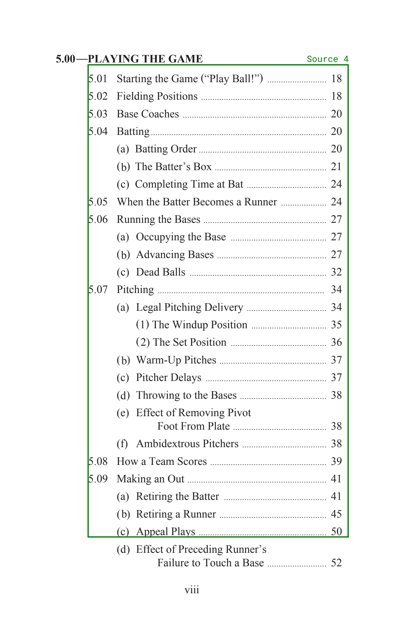

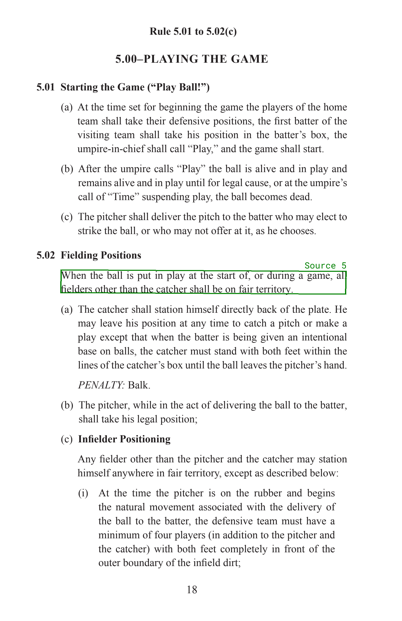

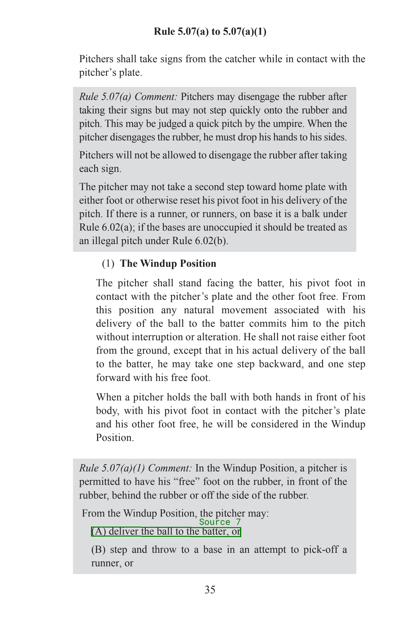

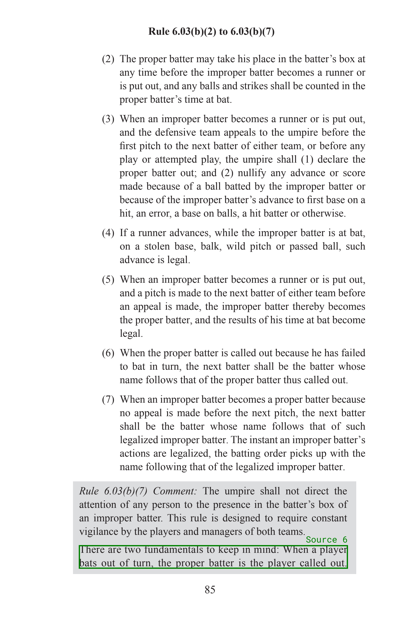

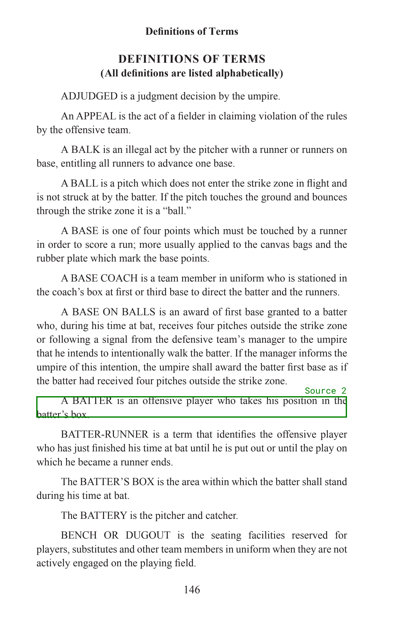

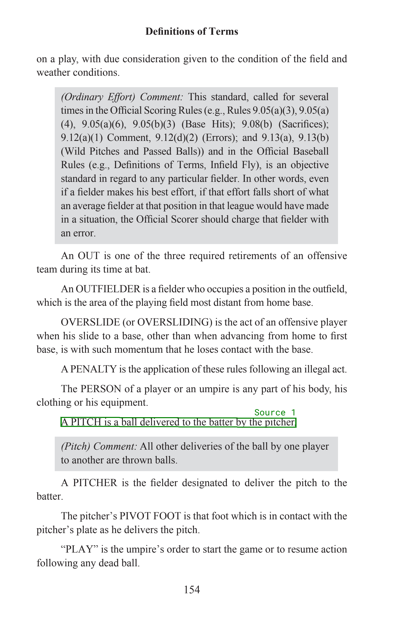

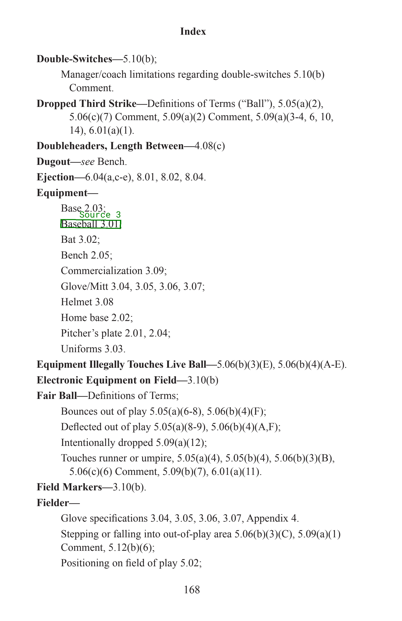

In [234]:
prompt = document_bot(question, display_contexts = True, display_annotations = True)

#### Get Grounded Response With Expanded Contexts, Print Out Contexts And Annotated Pages

**The Question:**

How is baseball played?



**The Response:**

The text provided does not explain how baseball is played; therefore, I cannot answer the question.



**Sources:**

Note: The 7 contexts were expanded to gather 93 additional chunks on pages with matches using a similarity distance of 1.
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=166
	* page: 166, similarity to question is 0.754
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=158
	* page: 158, similarity to question is 0.742
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=180
	* page: 180, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=8
	* page: 8, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=30
	* page: 30, similarity to question is 0.740
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=97
	* page: 97, similarity to question is 0.739
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=47
	* page: 47, similarity to question is 0.739


**Annotated Document Pages**



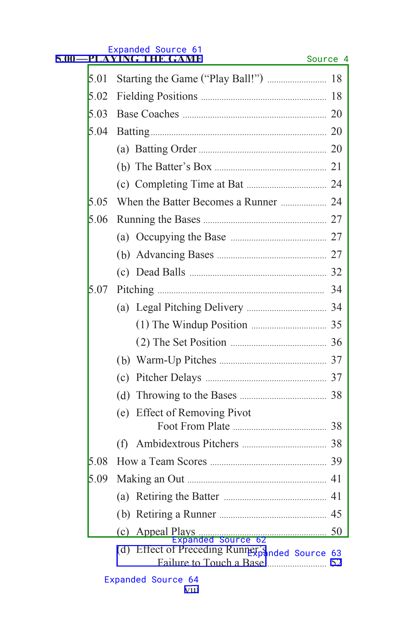

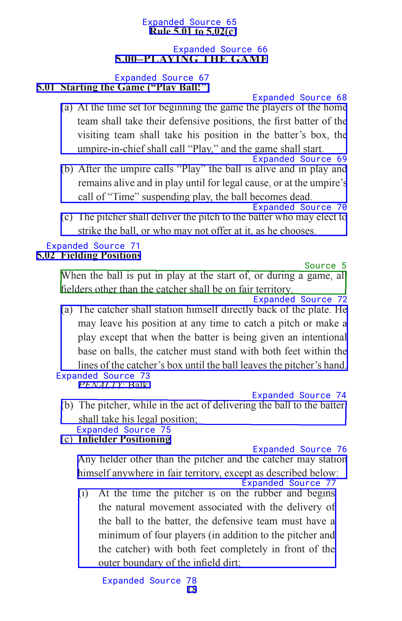

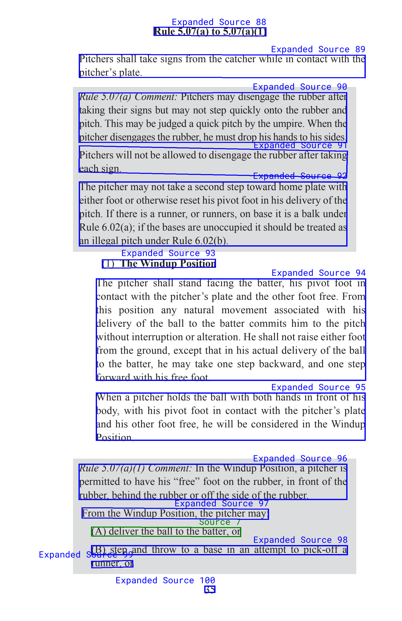

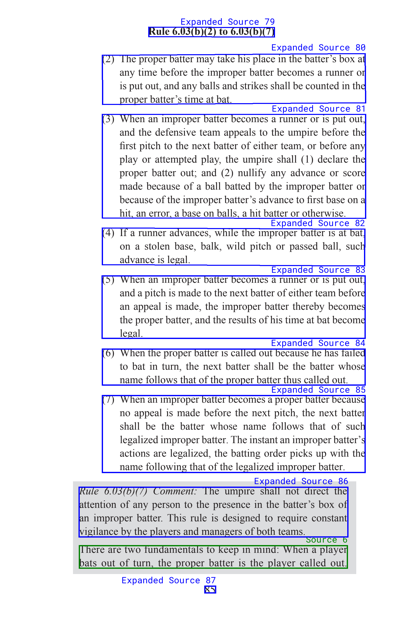

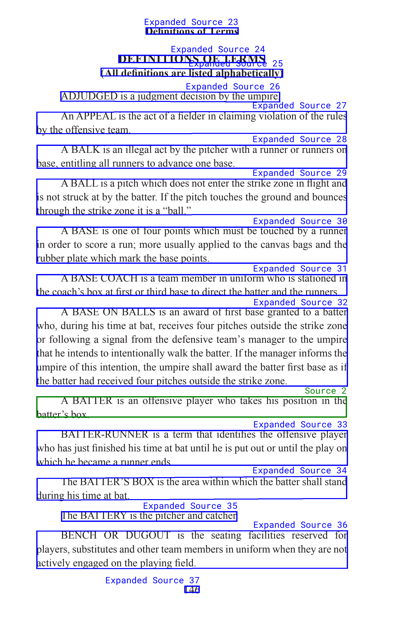

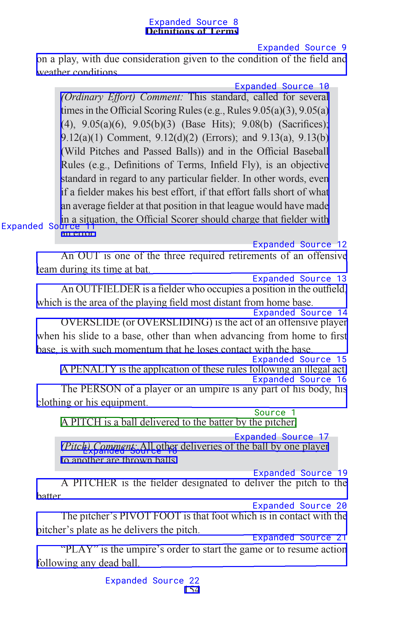

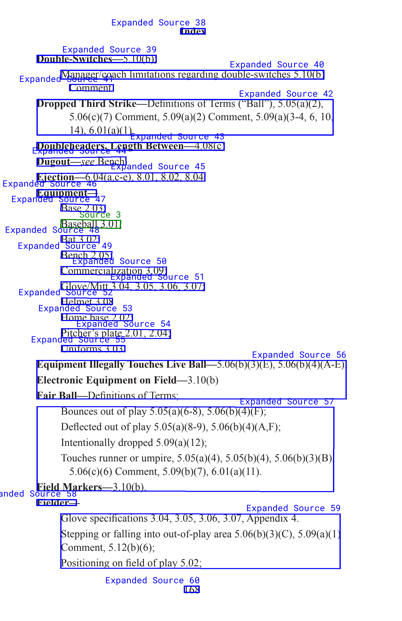

In [235]:
prompt = document_bot(question, DISTANCE = 1, display_contexts = True, display_annotations = True)

#### Get Grounded Response From Out Of Context Questions

Even though the question is on topic for the documents, baseball, it is about specific players and teams which is out of context of the indexed documents which are about the rules of the game of baseball.

In [236]:
prompt = document_bot('Who is the best pitcher for the Dodgers?')

**The Question:**

Who is the best pitcher for the Dodgers?



**The Response:**

The provided contexts do not contain any information about the best pitcher for the Dodgers. Therefore, I cannot answer this question from the provided contexts.



### Harder Questions

In [237]:
prompt = document_bot("What is the definition of a balk?", DISTANCE = 0.5)

**The Question:**

What is the definition of a balk?



**The Response:**

A balk is a rule violation by a pitcher that results in runners advancing one base without liability to be put out. There are different types of balks listed in the contexts provided. The first context, Context 1, mentions there is a balk but does not define it.

Context 3 provides a more specific definition of a balk. According to this context, a balk occurs when there is a runner or runners on base and the pitcher makes an illegal motion. The illegal motion must be one that is naturally associated with the pitcher's delivery, but the pitcher fails to complete the delivery. 

The context also mentions specific examples of what constitutes a balk, such as when the pitcher feints a throw to first or third base and fails to complete the throw or when the pitcher fails to step directly toward a base before throwing to that base.



In [238]:
prompt = document_bot("Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?", DISTANCE = 0.5)

**The Question:**

Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?



**The Response:**

1. We are looking for information about infielder positioning.
2. Rule 5.02(c) provides regulations on infielder positioning: No more than two infielders can be positioned on one side of the field or the other.
3. Therefore, if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball, a rule is broken.



**The Question:**

A batter hits a fair ball that goes over the outfield fence. Is this always a home run?



**The Response:**

1. **Read the provided contexts and identify the relevant information:**

   - Context 1 states that "A fair ball passes over a fence or into the stands at a distance from home base of 250 feet or more... entitles the batter to a home run when he shall have touched all bases legally."

2. **Apply the relevant information to the given question:**

   - The batter hit a fair ball that went over the outfield fence, which means it meets the distance requirement for a home run.

3. **Draw a conclusion based on the analysis:**

   - Since the ball went over the outfield fence and met the distance requirement, it is considered a home run, provided the batter legally touched all the bases.

Therefore, the answer is: **Yes, if the batter legally touched all the bases, it is always a home run when a fair ball goes over the outfield fence.**



**Sources:**

1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=36
	* page: 36, similarity to question is 0.855
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=41
	* page: 41, similarity to question is 0.841
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=52
	* page: 52, similarity to question is 0.826
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=162
	* page: 162, similarity to question is 0.824


**Annotated Document Pages**



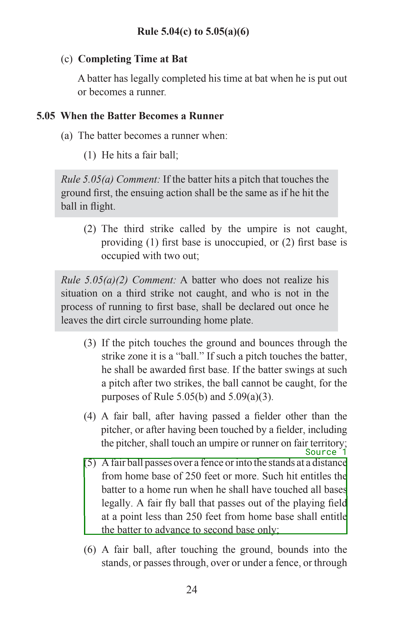

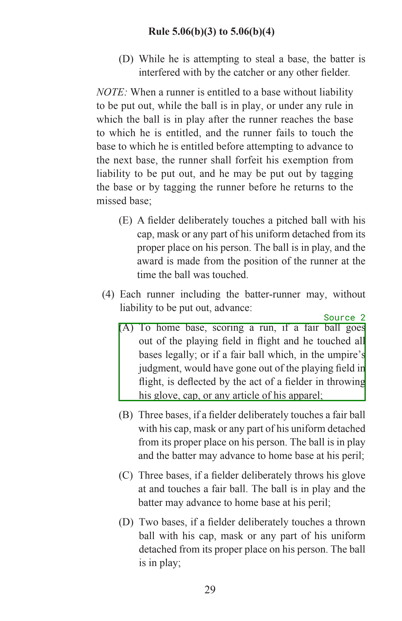

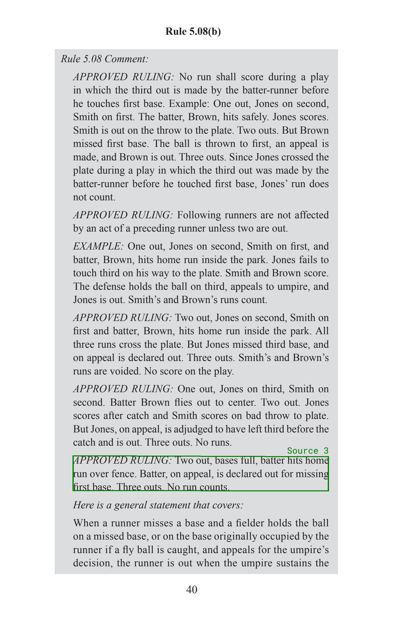

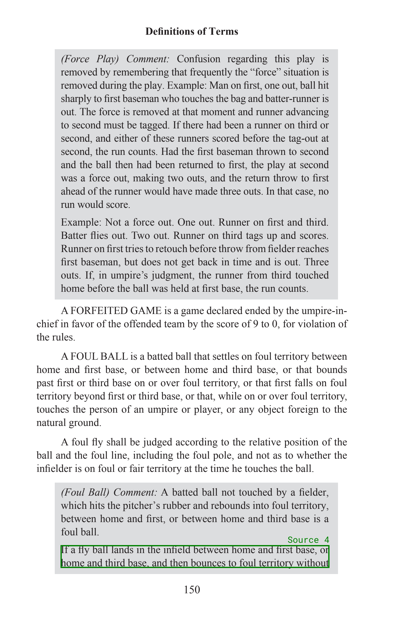

In [239]:
prompt = document_bot("A batter hits a fair ball that goes over the outfield fence. Is this always a home run?",display_contexts = True, display_annotations = True)

**The Question:**

Describe the shape of bases.



**The Response:**

The provided contexts do not contain any information about the shape of bases. So I cannot answer this question from the provided context.



**Sources:**

1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=51
	* page: 51, similarity to question is 0.775
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=143
	* page: 143, similarity to question is 0.747
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=177
	* page: 177, similarity to question is 0.746
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=39
	* page: 39, similarity to question is 0.741
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=180
	* page: 180, similarity to question is 0.740
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=39
	* page: 39, similarity to question is 0.735
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=143
	* page: 143, similarity to question is 0.735


**Annotated Document Pages**



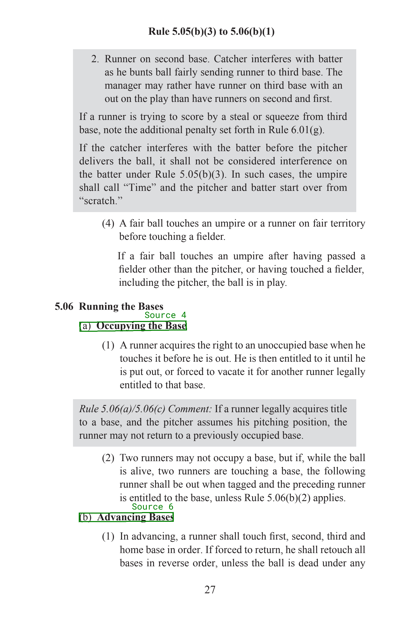

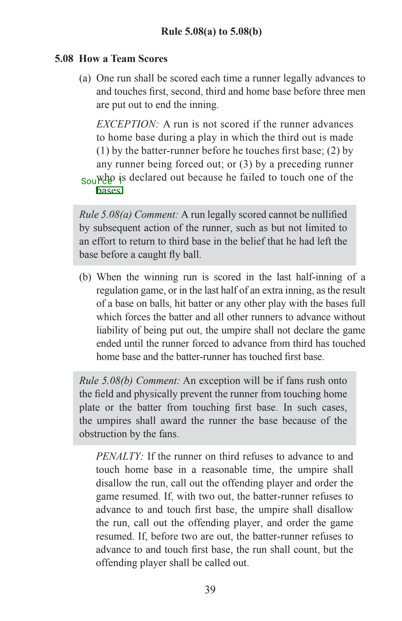

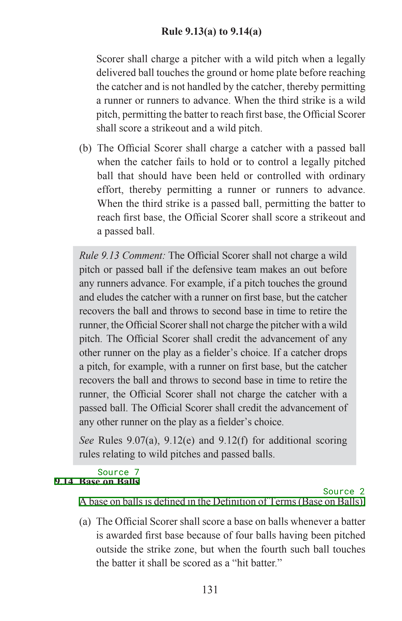

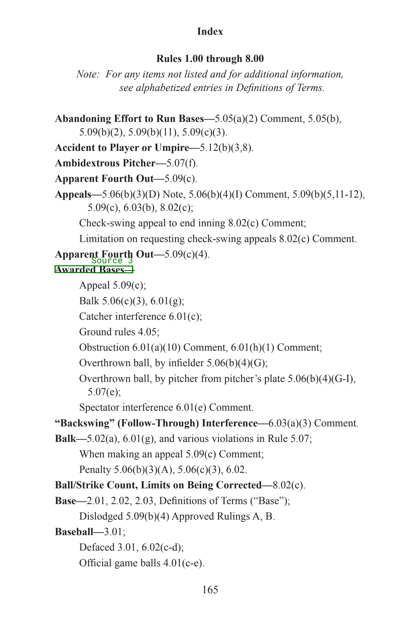

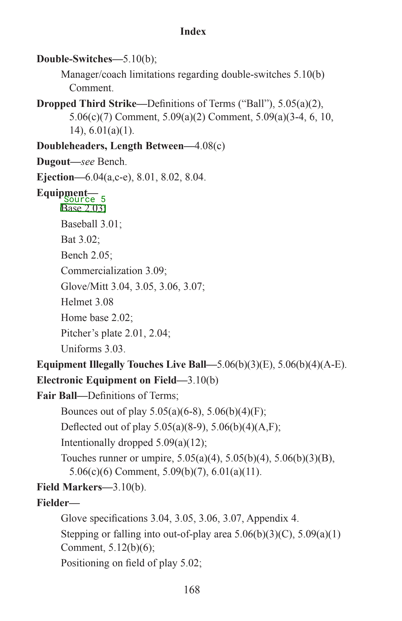

In [240]:
prompt = document_bot("Describe the shape of bases.",display_contexts = True, display_annotations = True)

---
## Next Steps!

While the document bots performs well and the configuation of `DISTANCE` allows users to gather expanded contexts, it still can be improved.

These enhancements will follow in additional notebooks:
- Enhanced context retrieval with a tree of contexts
    - This will provided a much better context for general questions that infer information from a broad section of the document. Like "How do I play baseball?"
- Multi-modal prompts
    - By included images from documents in the context retrieval and the prompt the context can also be inferred from the images.  This will help with the question about bases where the primary description in the rules is a graphic with dimensions.